In [1]:
# # use this code block to unzip the dataset.

# import zipfile
# with zipfile.ZipFile("casting_dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")

In [2]:
from IIP_Project import *

<center><img src="title.jpg"/></center>

<center><h1>Revolutionizing Quality Control in Production Lines</h1></center>
<center><h4>Harnessing the Power of Image Processing for Optimal Performance and Precision in Deep Learning Applications</h4></center>

***

In today's fast-paced industrial landscape, production lines play a pivotal role in ensuring efficient manufacturing processes and delivering high-quality products. The accuracy of production lines directly impacts the overall success and profitability of a business. One critical aspect of maintaining accuracy in the manufacturing industry is the detection and prevention of defects during the production process.

Manual inspection processes are time-consuming and prone to human errors, leading to inaccurate results and potential order rejections. To address this, leveraging image processing and deep learning models offers a solution. By training deep learning models on casting manufacturing datasets, businesses can automate defect detection and improve accuracy.

### Raw Image Preparation and Model Development
***

In defect detection for casting manufacturing, the initial step involves preparing raw images and developing a deep learning model. Raw images often contain imperfections and noise that can hinder accurate defect identification. Pre-processing techniques such as normalization and resizing are applied to optimize the raw images before feeding it into a deep learning model. In this project, we are going to fine-tune a resnet50 model that is pretrained on the imagenet1k dataset.

In [3]:
ok_front = 'casting_512x512/casting_512x512/ok_front'
def_front = 'casting_512x512/casting_512x512/def_front'

paths = [ok_front, def_front]

# this section should be manually changed depending on which
# directory you are trying to rename
# count = 1
# for filename in os.listdir(def_front):
#     if filename.endswith('.jpeg'):
#         new_name = f'def_front.{count}.jpeg'
#         os.rename(os.path.join(def_front, filename),
#                   os.path.join(def_front, new_name))
#         count += 1

In [4]:
# before creating a dataset let's see first how many
# images are there in each directory

for dir_path in paths:
    files_count = count_files(dir_path)
    print(f"Number of images in '{dir_path}': {files_count}")

Number of images in 'casting_512x512/casting_512x512/ok_front': 519
Number of images in 'casting_512x512/casting_512x512/def_front': 781


#### Creating the Raw Image Dataset:
***

In [5]:
# looping through create_dataset for each class
classes = ['ok_front', 'def_front']

for class_ in classes:
    src = 'casting_512x512/casting_512x512'
    
    dst = f'casting_512x512/casting_512x512/train/{class_}' # train
    create_dataset(src+'/'+class_, dst, range_=(1, 301), class_=class_)

    dst = f'casting_512x512/casting_512x512/validation/{class_}' # val
    create_dataset(src+'/'+class_, dst, range_=(301, 401), class_=class_)
    
    dst = f'casting_512x512/casting_512x512/test/{class_}' # test
    create_dataset(src+'/'+class_, dst, range_=(401, 501), class_=class_)

In [6]:
train_ok_front_dir =  'casting_512x512/casting_512x512/train/ok_front'
train_def_front_dir =  'casting_512x512/casting_512x512/train/def_front'

validation_ok_front_dir = 'casting_512x512/casting_512x512/validation/ok_front'
validation_def_front_dir = 'casting_512x512/casting_512x512/validation/def_front'

test_ok_front_dir = 'casting_512x512/casting_512x512/test/ok_front'
test_def_front_dir = 'casting_512x512/casting_512x512/test/def_front'

In [7]:
print('total training Ok front images:', len(os.listdir(train_ok_front_dir)))
print('total training Def front images:', len(os.listdir(train_def_front_dir)))

print('total validation Ok front images:', len(os.listdir(validation_ok_front_dir)))
print('total validation Def front images:', len(os.listdir(validation_def_front_dir)))

print('total test Ok front images:', len(os.listdir(test_ok_front_dir)))
print('total test Def front images:', len(os.listdir(test_def_front_dir)))

total training Ok front images: 300
total training Def front images: 300
total validation Ok front images: 100
total validation Def front images: 100
total test Ok front images: 100
total test Def front images: 100


In [8]:
data_path = Path("casting_512x512/casting_512x512")
image_path = data_path

image_path_list = list(image_path.glob("*/*/*.jpg"))

train_dir = image_path / "train"
val_dir = image_path / "validation"
test_dir = image_path / "test"

train_dir, val_dir, test_dir

(PosixPath('casting_512x512/casting_512x512/train'),
 PosixPath('casting_512x512/casting_512x512/validation'),
 PosixPath('casting_512x512/casting_512x512/test'))

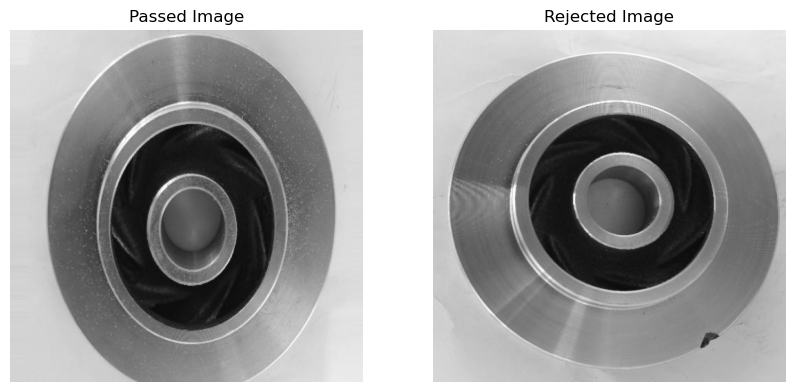

In [9]:
ok_image = Image.open('casting_512x512/casting_512x512/train/ok_front/ok_front.150.jpeg')
def_image = Image.open('casting_512x512/casting_512x512/train/def_front/def_front.150.jpeg')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(ok_image)
ax1.set_title('Passed Image')
ax1.axis('off')
ax2.imshow(def_image)
ax2.set_title('Rejected Image')
ax2.axis('off');

Here we can see sample images of the raw images for both the passed and the rejected casting results.

In [10]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms)
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

print(f'Means:           {means}') 
print(f'Std. Deviations: {stds}')

Means:           [0.5640641 0.5640641 0.5640641]
Std. Deviations: [0.24160852 0.24160852 0.24160852]


In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.6),             
        transforms.RandomPerspective(p=0.5),
        transforms.ColorJitter(brightness=0.5),              
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ])
}

data_dir = 'casting_512x512/casting_512x512'

# loading image data using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}

# dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}
# size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# class names
class_names = image_datasets['train'].classes

print(f'The classes in our dataset are the following:\n{class_names}')

The classes in our dataset are the following:
['def_front', 'ok_front']


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1') 
for param in model_conv.parameters():
    param.requires_grad = False

In [14]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
summary(model_conv, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [16]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(),
                           lr=0.001,
                           momentum=0.9)

num_ftrs_ft = model_conv.fc.in_features

model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs_ft, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)  
)

params_to_update = ['layer4.0.conv1.weight', 'layer4.0.conv1.bias',
                    'layer4.0.conv2.weight', 'layer4.0.conv2.bias',
                    'layer4.1.conv1.weight', 'layer4.1.conv1.bias',
                    'layer4.1.conv2.weight', 'layer4.1.conv2.bias',
                    'fc.0.weight', 'fc.0.bias',
                    'fc.3.weight', 'fc.3.bias']

params = []
for name, param in model_conv.named_parameters():
    for parameters in params_to_update:        
        if parameters in name:
            param.requires_grad = True
            params.append(param)

In [17]:
summary(model_conv, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [18]:
model_conv = train_model_with_patience(
    model_conv, 
    criterion, 
    optimizer_conv,
    dataloaders,
    device,
    dataset_sizes,
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.6929 Acc: 0.5083
validation Loss: 0.6696 Acc: 0.5150

Epoch 1/24
----------
train Loss: 0.6690 Acc: 0.5833
validation Loss: 0.6498 Acc: 0.6600

Epoch 2/24
----------
train Loss: 0.6637 Acc: 0.6033
validation Loss: 0.6263 Acc: 0.7850

Epoch 3/24
----------
train Loss: 0.6535 Acc: 0.6567
validation Loss: 0.6090 Acc: 0.8050

Epoch 4/24
----------
train Loss: 0.6333 Acc: 0.6900
validation Loss: 0.5883 Acc: 0.8050

Epoch 5/24
----------
train Loss: 0.6334 Acc: 0.6950
validation Loss: 0.5718 Acc: 0.8100

Epoch 6/24
----------
train Loss: 0.6147 Acc: 0.7233
validation Loss: 0.5515 Acc: 0.7850

Epoch 7/24
----------
train Loss: 0.6064 Acc: 0.7433
validation Loss: 0.5328 Acc: 0.8450

Epoch 8/24
----------
train Loss: 0.5839 Acc: 0.7750
validation Loss: 0.5218 Acc: 0.8500

Epoch 9/24
----------
train Loss: 0.5827 Acc: 0.7533
validation Loss: 0.5020 Acc: 0.8600

Epoch 10/24
----------
train Loss: 0.5816 Acc: 0.7650
validation Loss: 0.4822 Acc: 0.8550

Epoch 11/

In [19]:
# !rm ok_not_ok.pt
torch.save(model_conv.state_dict(), 'ok_not_ok.pt')

In [20]:
evaluate(model_conv, dataloaders['test'], device)

Test Accuracy: 0.9100


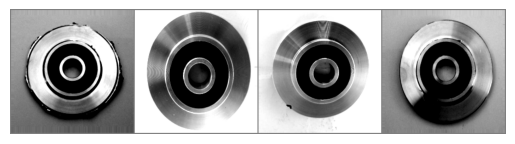

Real labels:  def_front ok_front def_front def_front
Predicted:  def_front ok_front ok_front def_front


In [21]:
visualize_preds(model_conv, dataloaders, device, class_names)

After performing fine-tuning on the resnet50 model, we got a 93.50 % accuracy which is above the proportional chance criterion of 62.50%.

### Processed Images Preparation and Model Development
***

In this section, we discuss the image preprocessing techniques employed to prepare our input images for the deep learning model. These techniques include horizontal and vertical edge detection, the white patch algorithm, and gradient norm analysis. These techniques enhance the images and contribute to the creation of a new dataset of processed images. The processed images exhibit improved edge features, and gradient representation, providing more informative inputs for the deep learning model.

In [22]:
import os

parent_directory = "./processed_images"
subdirectories = ["ok_front", "def_front"]


if os.path.exists(parent_directory):
    !rm -rf parent_directory
else:
    os.makedirs(parent_directory)

for subdirectory in subdirectories:
    path = os.path.join(parent_directory, subdirectory)
    if not os.path.exists(path):
        os.makedirs(path)

In [23]:
# Directory paths
input_directory = './casting_512x512/casting_512x512/ok_front'
output_directory = './processed_images/ok_front'

# Horizontal Sobel Filter
kernel1 = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

# Vertical Sobel Filter
kernel2 = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

image_files = glob.glob(os.path.join(input_directory, '*.jpeg'))


for file_path in tqdm(image_files):
    image = Image.open(file_path).convert('L')
    image_array = white_patch(np.array(image), 80)
    
    # Apply Sobel operators
    conv_hor = convolve2d(image_array, kernel1, 'valid')
    conv_ver = convolve2d(image_array, kernel2, 'valid')
    
    gradient = np.sqrt(conv_hor**2 + conv_ver**2)
    gradient_norm = (gradient - np.min(gradient)) / (np.max(gradient) - np.min(gradient))
    gradient_norm *= 255
    gradient_norm = gradient_norm.astype(np.uint8)
    
    file_name = os.path.basename(file_path)
    output_path = os.path.join(output_directory, file_name)
    plt.imsave(output_path, gradient_norm, cmap='gray')
    
print("Image processing complete.")

  0%|          | 0/519 [00:00<?, ?it/s]

Image processing complete.


In [24]:
# Directory paths
input_directory = './casting_512x512/casting_512x512/def_front'
output_directory = './processed_images/def_front'

# Horizontal Sobel Filter
kernel1 = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

# Vertical Sobel Filter
kernel2 = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])

image_files = glob.glob(os.path.join(input_directory, '*.jpeg'))


for file_path in tqdm(image_files):
    image = Image.open(file_path).convert('L')
    image_array = white_patch(np.array(image), 80)
    
    # Apply Sobel operators
    conv_hor = convolve2d(image_array, kernel1, 'valid')
    conv_ver = convolve2d(image_array, kernel2, 'valid')
    
    gradient = np.sqrt(conv_hor**2 + conv_ver**2)
    gradient_norm = (gradient - np.min(gradient)) / (np.max(gradient) - np.min(gradient))
    gradient_norm *= 255
    gradient_norm = gradient_norm.astype(np.uint8)
    
    file_name = os.path.basename(file_path)
    output_path = os.path.join(output_directory, file_name)
    plt.imsave(output_path, gradient_norm, cmap='gray')
    
print("Image processing complete.")

  0%|          | 0/781 [00:00<?, ?it/s]

Image processing complete.


#### Creating the Processed Images Dataset
***

In [25]:
# looping through create_dataset for each class
classes = ['ok_front', 'def_front']

for class_ in classes:
    src = 'processed_images'
    
    dst = f'processed_images/train/{class_}' # train
    create_dataset(src+'/'+class_, dst, range_=(1, 301), class_=class_)

    dst = f'processed_images/validation/{class_}' # val
    create_dataset(src+'/'+class_, dst, range_=(301, 401), class_=class_)
    
    dst = f'processed_images/test/{class_}' # test
    create_dataset(src+'/'+class_, dst, range_=(401, 501), class_=class_)

In [26]:
train_ok_front_dir =  'processed_images/train/ok_front'
train_def_front_dir =  'processed_images/train/def_front'

validation_ok_front_dir = 'processed_images/validation/ok_front'
validation_def_front_dir = 'processed_images/validation/def_front'

test_ok_front_dir = 'processed_images/test/ok_front'
test_def_front_dir = 'processed_images/test/def_front'

In [27]:
print('total training Ok front images:', len(os.listdir(train_ok_front_dir)))
print('total training Def front images:', len(os.listdir(train_def_front_dir)))

print('total validation Ok front images:', len(os.listdir(validation_ok_front_dir)))
print('total validation Def front images:', len(os.listdir(validation_def_front_dir)))

print('total test Ok front images:', len(os.listdir(test_ok_front_dir)))
print('total test Def front images:', len(os.listdir(test_def_front_dir)))

total training Ok front images: 300
total training Def front images: 300
total validation Ok front images: 100
total validation Def front images: 100
total test Ok front images: 100
total test Def front images: 100


In [28]:
data_path = Path("processed_images")
image_path = data_path

image_path_list = list(image_path.glob("*/*/*.jpg"))

train_dir = image_path / "train"
val_dir = image_path / "validation"
test_dir = image_path / "test"

train_dir, val_dir, test_dir

(PosixPath('processed_images/train'),
 PosixPath('processed_images/validation'),
 PosixPath('processed_images/test'))

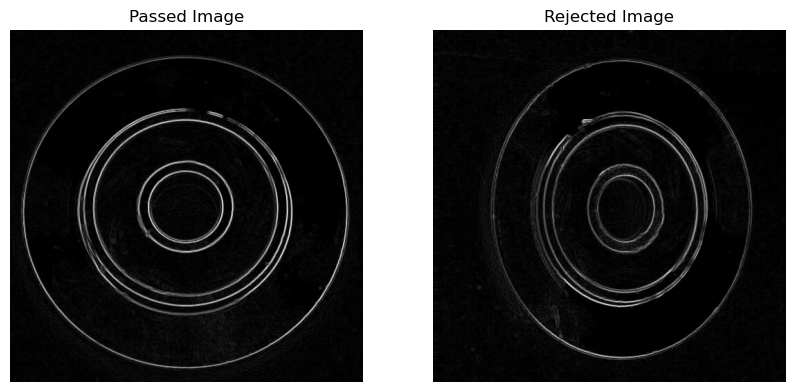

In [29]:
ok_image = Image.open('processed_images/train/ok_front/ok_front.20.jpeg')
def_image = Image.open('processed_images/train/def_front/def_front.20.jpeg')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(ok_image)
ax1.set_title('Passed Image')
ax1.axis('off')
ax2.imshow(def_image)
ax2.set_title('Rejected Image')
ax2.axis('off');

Here we can see sample images of the processed images for both the passed and the rejected casting results.

In [30]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms)
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

print(f'Means:           {means}') 
print(f'Std. Deviations: {stds}')

Means:           [0.03887142 0.03887142 0.03887142]
Std. Deviations: [0.077141 0.077141 0.077141]


In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.6),             
        transforms.RandomPerspective(p=0.5),
        transforms.ColorJitter(brightness=0.5),              
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ])
}

data_dir = 'processed_images'

# loading image data using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}

# dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}
# size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# class names
class_names = image_datasets['train'].classes

print(f'The classes in our dataset are the following:\n{class_names}')

The classes in our dataset are the following:
['def_front', 'ok_front']


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
model_conv_processed = torchvision.models.resnet50(weights='IMAGENET1K_V1') 
for param in model_conv_processed.parameters():
    param.requires_grad = False

In [34]:
print(model_conv_processed)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
summary(model_conv_processed, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [36]:
model_conv_processed = model_conv_processed.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv_processed.parameters(),
                           lr=0.001,
                           momentum=0.9)

num_ftrs_ft = model_conv_processed.fc.in_features

model_conv_processed.fc = nn.Sequential(
    nn.Linear(num_ftrs_ft, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)  
)

params_to_update = ['layer4.0.conv1.weight', 'layer4.0.conv1.bias',
                    'layer4.0.conv2.weight', 'layer4.0.conv2.bias',
                    'layer4.1.conv1.weight', 'layer4.1.conv1.bias',
                    'layer4.1.conv2.weight', 'layer4.1.conv2.bias',
                    'fc.0.weight', 'fc.0.bias',
                    'fc.3.weight', 'fc.3.bias']

params = []
for name, param in model_conv_processed.named_parameters():
    for parameters in params_to_update:        
        if parameters in name:
            param.requires_grad = True
            params.append(param)

In [37]:
summary(model_conv_processed, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [46]:
model_conv_processed = train_model_with_patience(
    model_conv_processed, 
    criterion, 
    optimizer_conv,
    dataloaders,
    device,
    dataset_sizes,
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.4701 Acc: 0.8633
validation Loss: 0.3770 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.4685 Acc: 0.8533
validation Loss: 0.3628 Acc: 0.9250

Epoch 2/24
----------
train Loss: 0.4586 Acc: 0.8550
validation Loss: 0.3730 Acc: 0.9000

Epoch 3/24
----------
train Loss: 0.4558 Acc: 0.8650
validation Loss: 0.3560 Acc: 0.9250

Epoch 4/24
----------
train Loss: 0.4786 Acc: 0.8567
validation Loss: 0.3584 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.4672 Acc: 0.8533
validation Loss: 0.3532 Acc: 0.9050

Epoch 6/24
----------
train Loss: 0.4550 Acc: 0.8683
validation Loss: 0.3173 Acc: 0.9400

Epoch 7/24
----------
train Loss: 0.4661 Acc: 0.8467
validation Loss: 0.3394 Acc: 0.9100

Epoch 8/24
----------
train Loss: 0.4208 Acc: 0.8950
validation Loss: 0.3312 Acc: 0.9550
Early stopping triggered.No improvement in validation loss for 2 epochs.
Training complete in 13m 48s
Best val Acc: 0.9400


In [47]:
evaluate(model_conv_processed, dataloaders['test'], device)

Test Accuracy: 0.9250


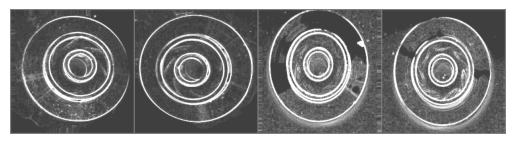

Real labels:  ok_front ok_front def_front ok_front
Predicted:  ok_front ok_front def_front ok_front


In [40]:
visualize_preds(model_conv_processed, dataloaders, device, class_names)

After performing fine-tuning on the resnet50 model, we got a 95.00 % accuracy for the processed image dataset which is higher than the raw image dataset accuracy of 93.50 %.

In [48]:
# !rm i_m_not_ok.pt
torch.save(model_conv_processed.state_dict(), 'i_m_not_ok.pt')

#### Conclusion
***

In summary, the utilization of the aforementioned image processing techniques has proven to be instrumental in extracting key features from casting manufacturing images, thereby enabling deep learning models to discern between rejected and passed casting results more effectively. The application of these techniques has resulted in a significant improvement in accuracy, with the processed images achieving a remarkable accuracy rate of 95% compared to the 93.5% accuracy achieved using raw images.

The impact of this enhanced accuracy is substantial for businesses operating in the casting manufacturing industry. By accurately detecting and classifying defects in real-time, companies can minimize the production of defective castings and reduce the likelihood of delivering substandard products to customers. This directly translates into improved product quality, enhanced customer satisfaction, and strengthened brand reputation.

The increase in accuracy from 93.5% to 95% may seem modest, but in the context of large-scale production lines, even slight improvements can yield significant cost savings. The implementation of image processing techniques and deep learning models for defect detection helps optimize the overall efficiency of the production process and minimizes financial losses associated with defective castings.

Furthermore, the introduction of automated defect detection systems, powered by deep learning models, accelerates the inspection process, leading to improved productivity and reduced inspection time. By replacing manual inspections, which are time-consuming and subject to human error, businesses can allocate resources more efficiently, streamline operations, and increase overall productivity.

Overall, the integration of image processing techniques and deep learning models in defect detection for casting manufacturing has a profound impact on business outcomes. The improved accuracy rates achieved through the processing of images not only enhance product quality but also contribute to cost savings, improved efficiency, and heightened customer satisfaction. Embracing automated defect detection systems can position companies at the forefront of technological advancements, enabling them to thrive in a competitive market while minimizing the risks and losses associated with casting defects.